# Plasma Data - Check of Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import sys
sys.path.append('../../utils')
from Architectures import FNN
from UPINN import UPINN

### Load data

In [3]:
data_files = np.load('data/100134_1.8MW_55s_aaro_5_3.npz', allow_pickle=True)
data = {key: data_files[key] for key in data_files.files}

In [54]:
x[:72]

array([0.        , 0.0106383 , 0.0212766 , 0.03191489, 0.04255319,
       0.05319149, 0.06382979, 0.07446809, 0.08510638, 0.09574468,
       0.10638298, 0.11702128, 0.12765957, 0.13829787, 0.14893617,
       0.15957447, 0.17021277, 0.18085106, 0.19148936, 0.20212766,
       0.21276596, 0.22340426, 0.23404255, 0.24468085, 0.25531915,
       0.26595745, 0.27659574, 0.28723404, 0.29787234, 0.30851064,
       0.31914894, 0.32978723, 0.34042553, 0.35106383, 0.36170213,
       0.37234043, 0.38297872, 0.39361702, 0.40425532, 0.41489362,
       0.42553191, 0.43617021, 0.44680851, 0.45744681, 0.46808511,
       0.4787234 , 0.4893617 , 0.5       , 0.5106383 , 0.5212766 ,
       0.53191489, 0.54255319, 0.55319149, 0.56382979, 0.57446809,
       0.58510638, 0.59574468, 0.60638298, 0.61702128, 0.62765957,
       0.63829787, 0.64893617, 0.65957447, 0.67021277, 0.68085106,
       0.69148936, 0.70212766, 0.71276596, 0.72340426, 0.73404255,
       0.74468085, 0.75531915])

In [ ]:
x_cap_idx = 72
x_lower_idx = 0

# Problem data
prob = data['prob'][()]
x = prob['x'][x_lower_idx:x_cap_idx]           # Normalized poloidal flux
D = prob['D'][x_lower_idx:x_cap_idx]           # Diffusion coefficient
V = prob['V'][x_lower_idx:x_cap_idx]           # Pinch velocity
S = prob['S'][x_lower_idx:x_cap_idx]           # Source term
dVdx = prob['dVdx'][x_lower_idx:x_cap_idx].reshape(-1, 1)  # Volume expansion term
g1 = prob['g1'][x_lower_idx:x_cap_idx].reshape(-1, 1)      # ⟨∇ρ⟩
g2 = prob['g2'][x_lower_idx:x_cap_idx].reshape(-1, 1)      # ⟨(∇ρ)^2⟩
bc = prob['bc'].reshape(-1, 1)                     # Boundary condition at psi_n ≈ 1.106 (or 1.0 ???)
n0 = prob['n0'][x_lower_idx:x_cap_idx].reshape(-1, 1)                     # Initial density
t = prob['tout']                    # Time
itaupar = prob['itaupar'][x_lower_idx:x_cap_idx] # Parallel loss time

# Solution data
sol = data['sol'][()]
ne = sol['ne'][x_lower_idx:x_cap_idx]         # Electron density (Found solution)

In [5]:
x_ = torch.tensor(x, dtype=torch.float32)
t_ = torch.tensor(t, dtype=torch.float32)
X, T = torch.meshgrid(x_, t_)
x_tensor = X.reshape(-1, 1)
t_tensor = T.reshape(-1, 1)
z_tensor = torch.cat((x_tensor, t_tensor), dim=1)

D_tensor = torch.tensor(D.reshape(-1, 1), dtype=torch.float32)
V_tensor = torch.tensor(V.reshape(-1, 1), dtype=torch.float32)
S_tensor = torch.tensor(S.reshape(-1, 1), dtype=torch.float32)

dVdx_tensor = torch.tensor(dVdx, dtype=torch.float32)
g1_tensor = torch.tensor(g1, dtype=torch.float32)
g2_tensor = torch.tensor(g2, dtype=torch.float32)
bc_tensor = torch.tensor(bc, dtype=torch.float32)
n0_tensor = torch.tensor(n0, dtype=torch.float32)

itaupar_tensor = torch.tensor(itaupar.reshape(-1, 1), dtype=torch.float32)
ne_tensor = torch.tensor(ne.reshape(-1, 1), dtype=torch.float32)


In [6]:
n0_net = FNN(
    dims=[1, 20, 20, 20, 1],
)
# model = UPINN(u=n0_net, data_points=(torch.tensor(x.reshape(-1,1), dtype=torch.float32), n0_tensor))
# model.optimizer = torch.optim.Adam(model.u.parameters())
# model.train_loop(10000)
# torch.save(n0_net.state_dict(), 'PlasmaNet/n0_net.pth')
n0_net.load_state_dict(torch.load('PlasmaNet/n0_net.pth'))

<All keys matched successfully>

In [7]:
dVdx_net = FNN(
    dims=[1, 20, 20, 20, 1],
    output_act=torch.nn.ReLU(),
)
# model = UPINN(u=dVdx_net, data_points=(torch.tensor(x.reshape(-1,1), dtype=torch.float32), dVdx_tensor))
# model.optimizer = torch.optim.Adam(model.u.parameters())
# model.train_loop(10000)
# torch.save(dVdx_net.state_dict(), 'PlasmaNet/dVdx_net.pth')
dVdx_net.load_state_dict(torch.load('PlasmaNet/dVdx_net.pth'))

<All keys matched successfully>

In [8]:
g1_net = FNN(
    dims=[1, 20, 20, 20, 1],
)
# model = UPINN(u=g1_net, data_points=(torch.tensor(x.reshape(-1,1), dtype=torch.float32), g1_tensor))
# model.optimizer = torch.optim.Adam(model.u.parameters())
# model.train_loop(1000)
# torch.save(g1_net.state_dict(), 'PlasmaNet/g1_net.pth')
g1_net.load_state_dict(torch.load('PlasmaNet/g1_net.pth'))

<All keys matched successfully>

In [9]:
g2_net = FNN(
    dims=[1, 20, 20, 20, 1],
)
# model = UPINN(u=g2_net, data_points=(torch.tensor(x.reshape(-1,1), dtype=torch.float32), g2_tensor))
# model.optimizer = torch.optim.Adam(model.u.parameters())
# model.train_loop(1000)
# torch.save(g2_net.state_dict(), 'PlasmaNet/g2_net.pth')
g2_net.load_state_dict(torch.load('PlasmaNet/g2_net.pth'))

<All keys matched successfully>

In [10]:
bc_net = FNN(
    dims=[1, 20, 20, 20, 1],
)
# model = UPINN(u=bc_net, data_points=(torch.tensor(t.reshape(-1,1), dtype=torch.float32), bc_tensor))
# model.optimizer = torch.optim.Adam(model.u.parameters())
# model.train_loop(10000)
# torch.save(bc_net.state_dict(), 'PlasmaNet/bc_net.pth')
bc_net.load_state_dict(torch.load('PlasmaNet/bc_net.pth'))

<All keys matched successfully>

In [11]:
D_net = FNN(
    dims=[2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
    output_act=torch.nn.ReLU(),
)
# model = UPINN(u=D_net, data_points=(z_tensor, D_tensor))
# model.optimizer = torch.optim.LBFGS(model.u.parameters())
# model.train_loop(200)
# torch.save(D_net.state_dict(), 'PlasmaNet/D_net.pth')
D_net.load_state_dict(torch.load('PlasmaNet/D_net.pth'))

<All keys matched successfully>

In [12]:
V_net = FNN(
    dims=[2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
)
# model = UPINN(u=V_net, data_points=(z_tensor, V_tensor))
# model.optimizer = torch.optim.LBFGS(model.u.parameters())
# model.train_loop(200)
# torch.save(V_net.state_dict(), 'PlasmaNet/V_net.pth')
V_net.load_state_dict(torch.load('PlasmaNet/V_net.pth'))

<All keys matched successfully>

In [13]:
S_net = FNN(
    dims=[2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
)
# model = UPINN(u=S_net, data_points=(z_tensor, S_tensor))
# model.optimizer = torch.optim.Adam(model.u.parameters())
# model.train_loop(10000)
# torch.save(S_net.state_dict(), 'PlasmaNet/S_net.pth')
S_net.load_state_dict(torch.load('PlasmaNet/S_net.pth'))

<All keys matched successfully>

In [14]:
itaupar_net = FNN(
    dims=[2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
    output_act=torch.nn.ReLU(),
)
# model = UPINN(u=itaupar_net, data_points=(z_tensor, itaupar_tensor))
# model.optimizer = torch.optim.LBFGS(model.u.parameters())
# model.train_loop(200)
# torch.save(itaupar_net.state_dict(), 'PlasmaNet/itaupar_net.pth')
itaupar_net.load_state_dict(torch.load('PlasmaNet/itaupar_net.pth'))

<All keys matched successfully>

In [15]:
ne_net = FNN(
    dims=[2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
    # output_act=torch.nn.ReLU(),
)
# model = UPINN(u=ne_net, data_points=(z_tensor, ne_tensor))
# model.optimizer = torch.optim.Adam(model.u.parameters())
# model.train_loop(10000)
# torch.save(ne_net.state_dict(), 'PlasmaNet/ne_net.pth')
ne_net.load_state_dict(torch.load('PlasmaNet/ne_net.pth'))

<All keys matched successfully>

## Visualize neural network approximations of the plasma data

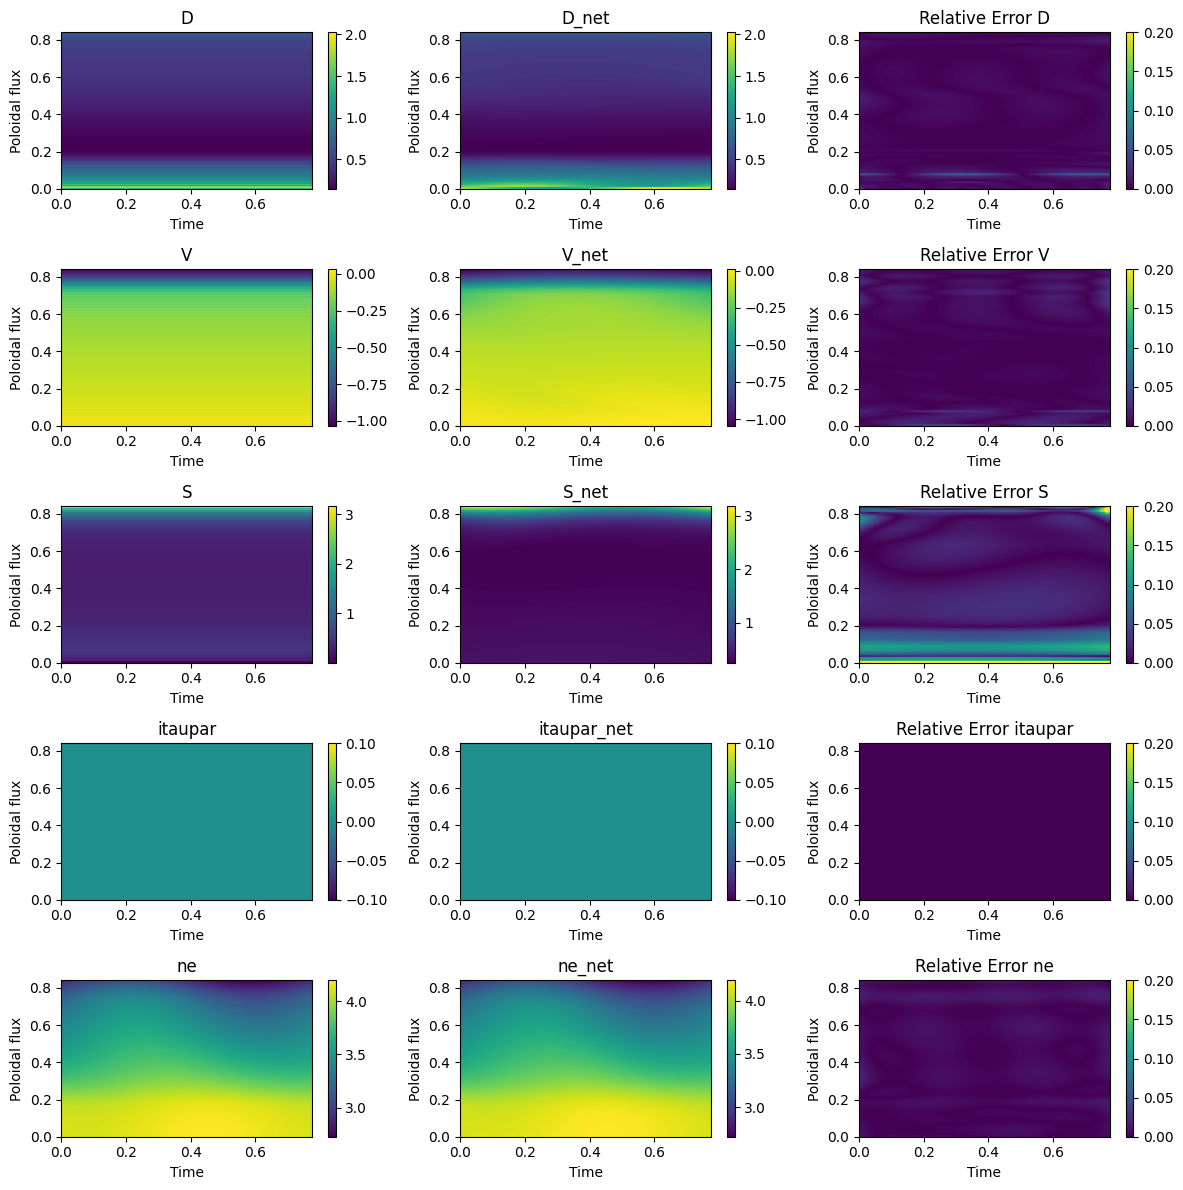

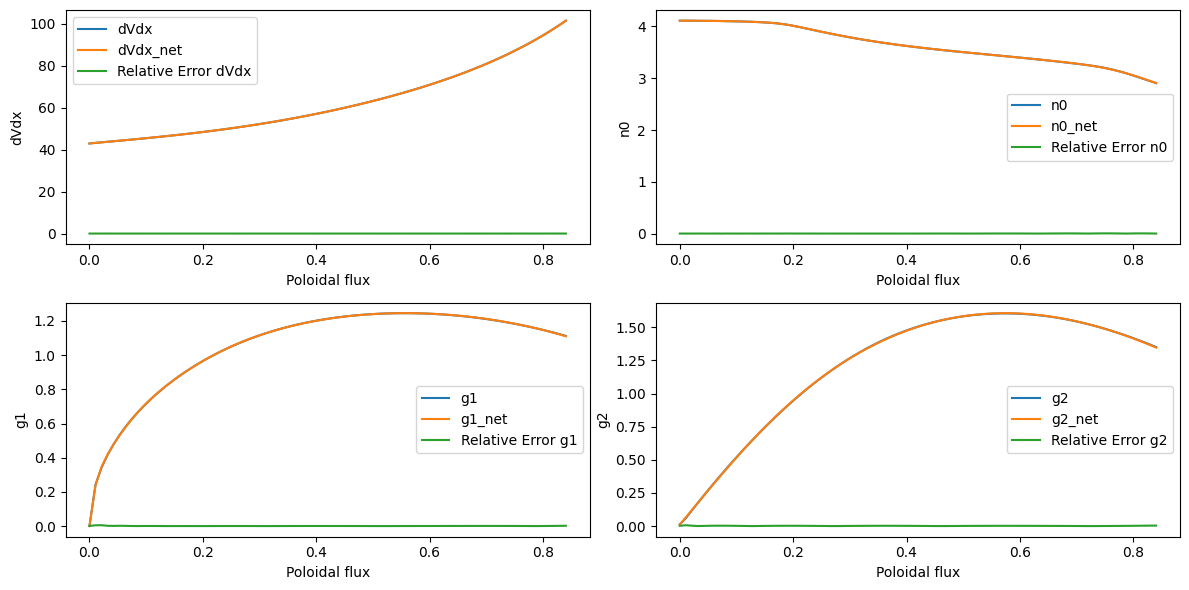

In [16]:
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
params = [('D', D_tensor, D_net), ('V', V_tensor, V_net), ('S', S_tensor, S_net), ('itaupar', itaupar_tensor, itaupar_net), ('ne', ne, ne_net)]

for i, (label, true_val, net_func) in enumerate(params):
    net_val = net_func(z_tensor).detach().numpy().reshape(len(x), len(t))
    abs_error = abs(true_val.reshape(len(x), len(t)) - net_val)
    for j, (data, title) in enumerate([(true_val, label), (net_val, f'{label}_net'), (abs_error, f'Relative Error {label}')]):
        cbar_kwargs = dict(vmin=0, vmax=0.2) if j == 2 else {}
        im = axs[i, j].imshow(data, aspect='auto', origin='lower', extent=[t[0], t[-1], x[0], x[-1]], **cbar_kwargs)
        axs[i, j].set_title(title)
        axs[i, j].set_xlabel('Time')
        axs[i, j].set_ylabel('Poloidal flux')
        plt.colorbar(im, ax=axs[i, j])
        

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.flatten()
params = [('dVdx', dVdx, dVdx_net), ('n0', n0, n0_net), ('g1', g1, g1_net), ('g2', g2, g2_net)]

for i, (label, true_val, net_func) in enumerate(params):
    net_val = net_func(torch.tensor(x.reshape(-1, 1), dtype=torch.float32)).detach().numpy()
    abs_error = abs(true_val - net_val)
    for j, (data, title) in enumerate([(true_val, label), (net_val, f'{label}_net'), (abs_error, f'Relative Error {label}')]):
        axs[i].plot(x, data, label=title)
        axs[i].set_xlabel('Poloidal flux')
        axs[i].set_ylabel(label)
        axs[i].legend()

plt.tight_layout()
plt.show()

In [17]:
class Continuity(torch.nn.Module):
    def __init__(self, n0_net, dVdx_net, g1_net, g2_net, D_net, V_net, S_net, itaupar_net, ne_net):
        super(Continuity, self).__init__()
        self.n0_net = n0_net
        self.dVdx_net = dVdx_net
        self.g1_net = g1_net
        self.g2_net = g2_net
        self.D_net = D_net
        self.V_net = V_net
        self.S_net = S_net
        self.itaupar_net = itaupar_net
        self.ne_net = ne_net

        # Make sure the networks are not trainable
        for param in self.n0_net.parameters():
            param.requires_grad = False
        for param in self.dVdx_net.parameters():
            param.requires_grad = False
        for param in self.g1_net.parameters():
            param.requires_grad = False
        for param in self.g2_net.parameters():
            param.requires_grad = False
        for param in self.D_net.parameters():
            param.requires_grad = False
        for param in self.V_net.parameters():
            param.requires_grad = False
        for param in self.S_net.parameters():
            param.requires_grad = False
        for param in self.itaupar_net.parameters():
            param.requires_grad = False
        for param in self.ne_net.parameters():
            param.requires_grad = False

    def forward(self, xt, ne):
        dVdx = self.dVdx_net(xt[:, 0:1])
        dnedxt = torch.autograd.grad(ne, xt, grad_outputs=torch.ones_like(ne), create_graph=True)[0]
        dnedx = dnedxt[:, 0:1]
        dnedt = dnedxt[:, 1:2]
        g1 = self.g1_net(xt[:, 0:1])
        g2 = self.g2_net(xt[:, 0:1])
        D = self.D_net(xt)
        V = self.V_net(xt)
        S = self.S_net(xt)
        itaupar = self.itaupar_net(xt)

        h = dVdx * (g2*D*dnedx - g1*V*ne)

        dhdx = torch.autograd.grad(h, xt, grad_outputs=torch.ones_like(h), create_graph=True)[0][:, 0:1]

        return dVdx * dnedt - dhdx - dVdx*(S-ne*itaupar)

N = Continuity(n0_net, dVdx_net, g1_net, g2_net, D_net, V_net, S_net, itaupar_net, ne_net)
# z_tensor.requires_grad = True
# ne_pred = ne_net(z_tensor)
# torch.mean(abs(N(z_tensor, ne_pred)))


In [38]:
ne_tensor

tensor([[4.1129],
        [4.1103],
        [4.1083],
        ...,
        [2.8598],
        [2.8830],
        [2.9067]])

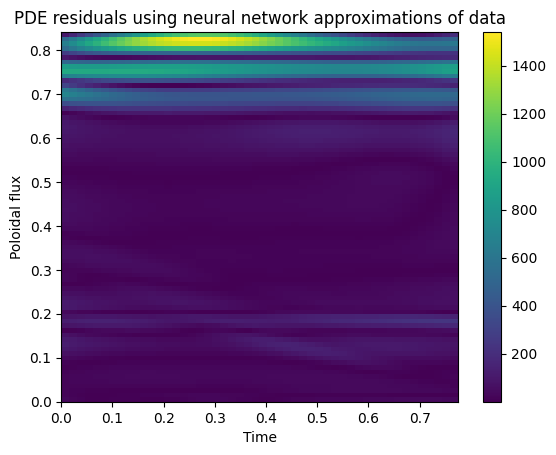

In [48]:
z_tensor.requires_grad = True
N(z_tensor, ne_net(z_tensor))

plt.imshow(abs(N(z_tensor, ne_net(z_tensor)).detach().numpy().reshape(len(x), len(t))), aspect='auto', origin='lower', extent=[t[0], t[-1], x[0], x[-1]])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Poloidal flux')
plt.title('PDE residuals using neural network approximations of data')
plt.show()

$$ \frac{\partial \mathcal{V}}{\partial \rho} \frac{\partial n_e}{\partial t} = \frac{\partial}{\partial \rho} \frac{\partial \mathcal{V}}{\partial \rho} \left(   \langle \nabla \rho)^2 \rangle D \frac{\partial n_e}{\partial \rho} -  \langle \nabla \rho \rangle V n_e \right) + \frac{\partial \mathcal{V}}{\partial \rho} \left( S - \frac{n_e}{\tau_{||}} \right) $$

In [18]:
# Sample sobol points
n_sobol = 10000
sobol = torch.quasirandom.SobolEngine(dimension=2)
Zc = sobol.draw(n_sobol)
Zc[:, 0] = Zc[:, 0] * (x.max() - x.min()) + x.min()
Zc[:, 1] = Zc[:, 1] * (t.max() - t.min()) + t.min()

In [19]:
xb = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
Zb = torch.cat((xb, torch.zeros_like(xb)), dim=1)
ub = n0_tensor

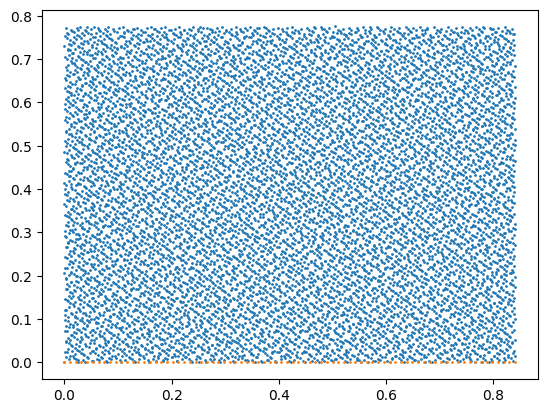

In [20]:
plt.figure()
plt.scatter(Zc[:, 0], Zc[:, 1], s=1)
plt.scatter(Zb[:, 0], Zb[:, 1], s=1)
plt.show()

In [35]:
class UPINN(UPINN):

    def get_loss(self):
        bc_loss = self.bc_loss()*10
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()*0
        loss = bc_loss + data_loss + pde_loss
        return loss, bc_loss, data_loss, pde_loss

In [36]:
u = FNN(
    dims=[2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
)
model = UPINN(u=u, N=N, boundary_points=(Zb, ub), collocation_points=Zc)
model.optimizer = torch.optim.AdamW(model.u.parameters())

model.train_loop(10000)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)
[Info]: Training 10000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 10000/10000 [04:15<00:00, 39.09 epoch/s, L=7.52e-05, L_bc=7.52e-05, L_data=0.00e+00, L_pde=0.00e+00]


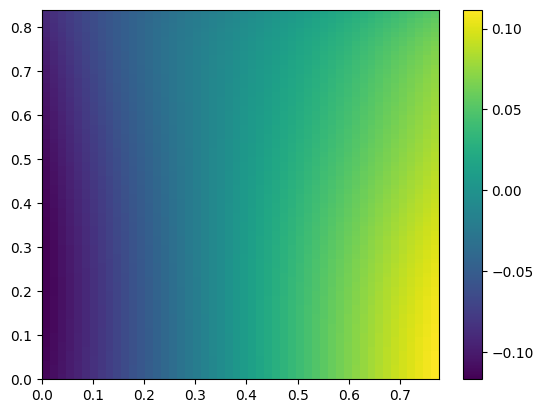

In [30]:
model.to('cpu')
plt.imshow(u(z_tensor).detach().numpy().reshape(len(x), len(t)), origin='lower', aspect='auto', extent=[t[0], t[-1], x[0], x[-1]])
plt.colorbar()

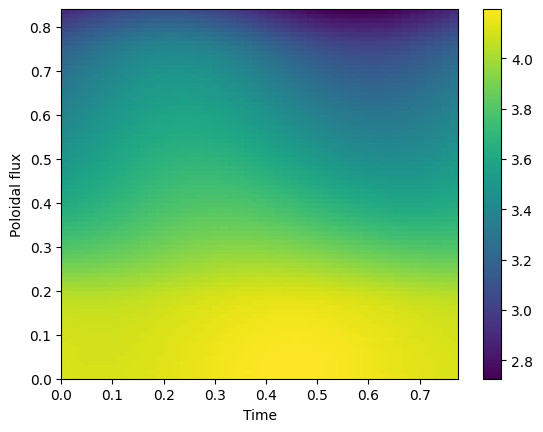

In [28]:
plt.imshow(ne, origin='lower', aspect='auto', extent=[t[0], t[-1], x[0], x[-1]])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Poloidal flux')
plt.show()

Problem

In [213]:
ne_pred = ne_net(z_tensor)
dnedt = torch.autograd.grad(ne_pred, z_tensor, grad_outputs=torch.ones_like(ne_pred), create_graph=True)[0][:, 1:2]

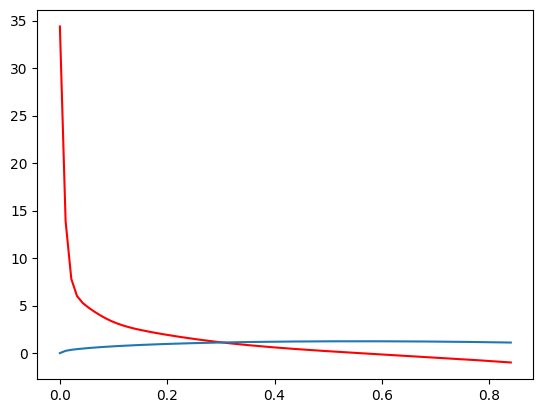

In [214]:
g = g1_net(z_tensor[:, 0:1])
dgdz = torch.autograd.grad(g, z_tensor, grad_outputs=torch.ones_like(g), create_graph=True)[0][:, 0:1]

plt.plot(x_tensor, dgdz.detach().numpy(), color='r')
plt.plot(x_tensor, g.detach().numpy())

Mean PDE residual: 14.776592197438964


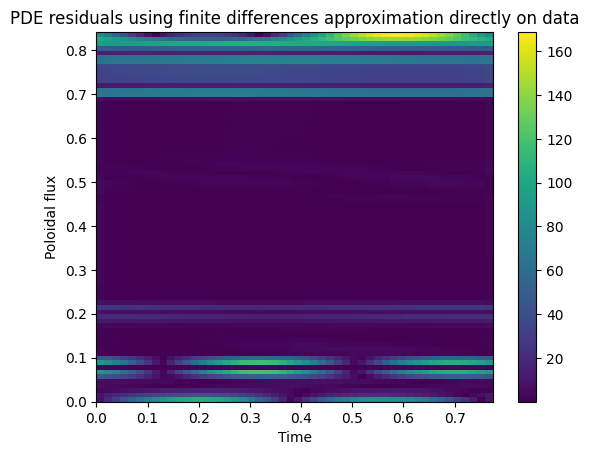

In [49]:
# Temporal derivative
dndt = np.gradient(ne, t, axis=1)

# Spatial derivative
dndx = np.gradient(ne, x, axis=0)

# PDE residual
residual = dVdx*dndt - np.gradient(dVdx*(g2*D*dndx - g1*V*ne), x, axis=0) - dVdx*(S - ne*itaupar)

print("Mean PDE residual:", np.mean(abs(residual)))

plt.imshow(abs(residual), origin='lower', aspect='auto', extent=[t[0], t[-1], x[0], x[-1]])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Poloidal flux')
plt.title('PDE residuals using finite differences approximation directly on data')
plt.show()

$$ \frac{\partial \mathcal{V}}{\partial \rho} \frac{\partial n_e}{\partial t} = \frac{\partial}{\partial \rho} \frac{\partial \mathcal{V}}{\partial \rho} \left(  ( \langle \nabla \rho)^2 \rangle D \frac{\partial n_e}{\partial \rho} -  \langle \nabla \rho \rangle V n_e \right) + \frac{\partial \mathcal{V}}{\partial \rho} \left( S - \frac{n_e}{\tau_{||}} \right) $$

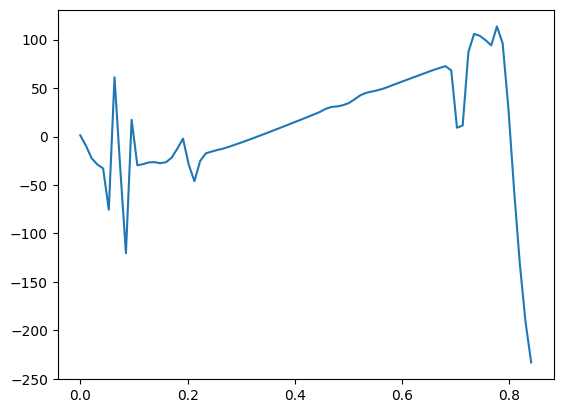

In [50]:
# plt.plot(x, dVdx*dndt, label='dVdx*dndt')
plt.plot(x, (np.gradient(dVdx*(g2*D*dndx - g1*V*ne), x, axis=0))[:, 0], label='∇•(D∇n - Vn)')
# plt.plot(x, (dVdx*(S - n_e*itaupar))[:, 0], label='dVdx*(S - n*itaupar)')

plt.show()

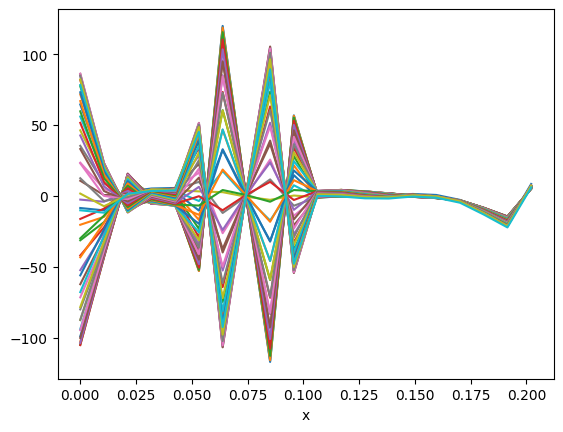

In [217]:
plt.plot(x[:20], residual[:20], label='res')
# plt.plot(x, (np.gradient(dVdx*(g2*D*dndx - g1*V*n_e), x, axis=0))[:, 0], label='∇•(D∇n - Vn)')
# plt.plot(x, (dVdx*(S - n_e*itaupar))[:, 0], label='dVdx*(S - n*itaupar)')
plt.xlabel('x')
plt.show()

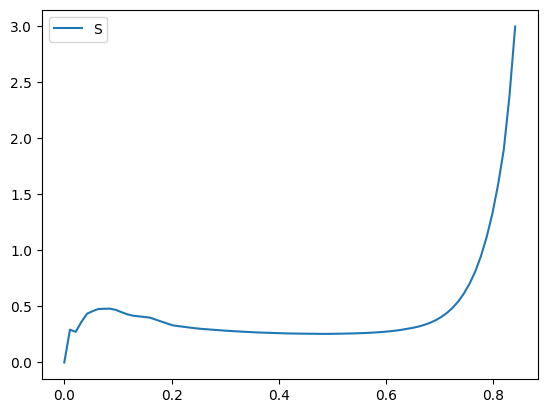

In [218]:
plt.plot(x, S[:, 0], label='S')
plt.legend()
plt.show()

In [219]:
# Make D and V functions of t and x using interpolation from torch
D = torch.tensor(D) if type(D) == np.ndarray else D
V = torch.tensor(V) if type(V) == np.ndarray else V
S = torch.tensor(S) if type(S) == np.ndarray else S
dVdx = torch.tensor(dVdx) if type(dVdx) == np.ndarray else dVdx
g1 = torch.tensor(g1) if type(g1) == np.ndarray else g1
g2 = torch.tensor(g2) if type(g2) == np.ndarray else g2

new_D = torch.nn.functional.interpolate(D.unsqueeze(0).unsqueeze(0), size=(len(x)*2, 2*len(tout)), mode='bicubic')


NameError: name 'tout' is not defined

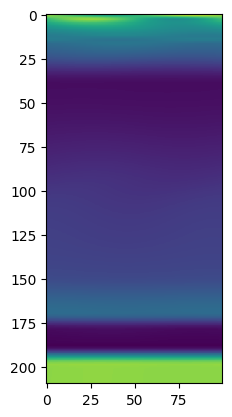

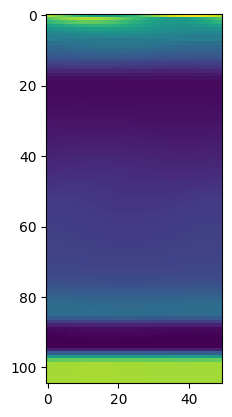

In [ ]:
plt.imshow(new_D.squeeze().detach().numpy())
plt.show()
plt.imshow(D.detach().numpy())
plt.show()

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# Load dataset (assuming you have it as NumPy arrays)
# x = np.load(...)  # Shape (105,)
# D = np.load(...)  # Shape (105, 50)
# V = np.load(...)  # Shape (105, 50)
# S = np.load(...)  # Shape (105, 50)
# g1 = np.load(...) # Shape (105,)
# g2 = np.load(...) # Shape (105,)
# itaupar = np.load(...) # Shape (105, 50)

# Time and space grid
nx = 105
nt = 50
dx = np.gradient(x)  # Compute grid spacing
dt = tout[1] - tout[0]  # Assuming uniform time steps

# Initialize n_e
ne = np.zeros((nx, nt))
ne[:, 0] = n0  # Initial condition

# Loop over time steps
for t in range(1, nt):
    D_t = D[:, t]  # Diffusion coefficient at time t
    V_t = V[:, t]  # Convection velocity at time t
    S_t = S[:, t]  # Source term at time t
    taupar_inv = itaupar[:, t]  # 1/tau_parallel
    
    # Construct matrix for Crank-Nicolson
    A = sp.lil_matrix((nx, nx))
    b = np.zeros(nx)
    
    for i in range(1, nx - 1):
        dxL = dx[i - 1]
        dxR = dx[i]
        g1i = g1[i]
        g2i = g2[i]
        
        D_effL = g2i * D_t[i - 1] / dxL
        D_effR = g2i * D_t[i] / dxR
        V_eff = g1i * V_t[i]
        
        A[i, i - 1] = -dt * D_effL
        A[i, i] = 1 + dt * (D_effL + D_effR) + dt * taupar_inv[i]
        A[i, i + 1] = -dt * D_effR
        b[i] = ne[i, t - 1] + dt * (S_t[i] - ne[i, t - 1] * taupar_inv[i])
    
    # Boundary conditions
    A[0, 0] = 1  # Zero flux at x=0
    A[90, 90] = 1  # Dirichlet BC at x=1.1 (ne=0)
    b[0] = ne[0, t - 1]
    b[90] = 0
    
    # Solve linear system
    ne[:, t] = spla.spsolve(A.tocsr(), b)

# Save results
# np.save("ne_solution.npy", ne)


C:\Users\jonas\AppData\Local\Temp\ipykernel_8268\1970754747.py:57: MatrixRankWarning: Matrix is exactly singular
  ne[:, t] = spla.spsolve(A.tocsr(), b)


Solution

In [ ]:
sol = data['sol'][()]

n_e = sol['ne']                     # Electron density (Found solution)

In [ ]:
n_e-ne

array([[ 0., nan, nan, ..., nan, nan, nan],
       [ 0., nan, nan, ..., nan, nan, nan],
       [ 0., nan, nan, ..., nan, nan, nan],
       ...,
       [ 0., nan, nan, ..., nan, nan, nan],
       [ 0., nan, nan, ..., nan, nan, nan],
       [ 0., nan, nan, ..., nan, nan, nan]])

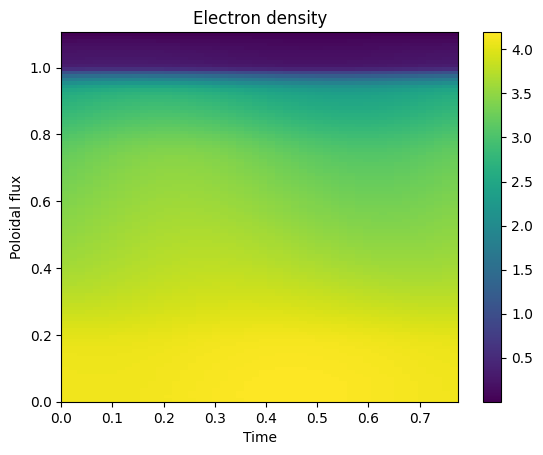

In [ ]:
plt.imshow(abs(n_e), aspect='auto', origin='lower', extent=[tout[0], tout[-1], x[0], x[-1]])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Poloidal flux')
plt.title('Electron density')
plt.show()

### Check that solution satisfies PDE

The solution should satisfy the continuity equation,
$$
\frac{\partial n_e}{\partial t} + \nabla \cdot (D \nabla n_e - V n_e) = S - \frac{n_e}{\tau_{||}},
$$

which in poloidal flux coordinates of $\psi_n$ becomes,
$$
\frac{\partial n_e}{\partial t} + \frac{\partial}{\partial \psi_n} \left(D \frac{\partial n_e}{\partial \psi_n} - V n_e \right) = S - \frac{n_e}{\tau_{||}},
$$
or fully expanded,
$$
\frac{\partial n_e}{\partial t} + D \frac{\partial^2 n_e}{\partial \psi_n^2} + \frac{\partial D}{\partial \psi_n} \frac{\partial n_e}{\partial \psi_n} - V \frac{\partial n_e}{\partial \psi_n} - \frac{\partial V}{\partial \psi_n} n_e = S - \frac{n_e}{\tau_{\parallel}}.
$$

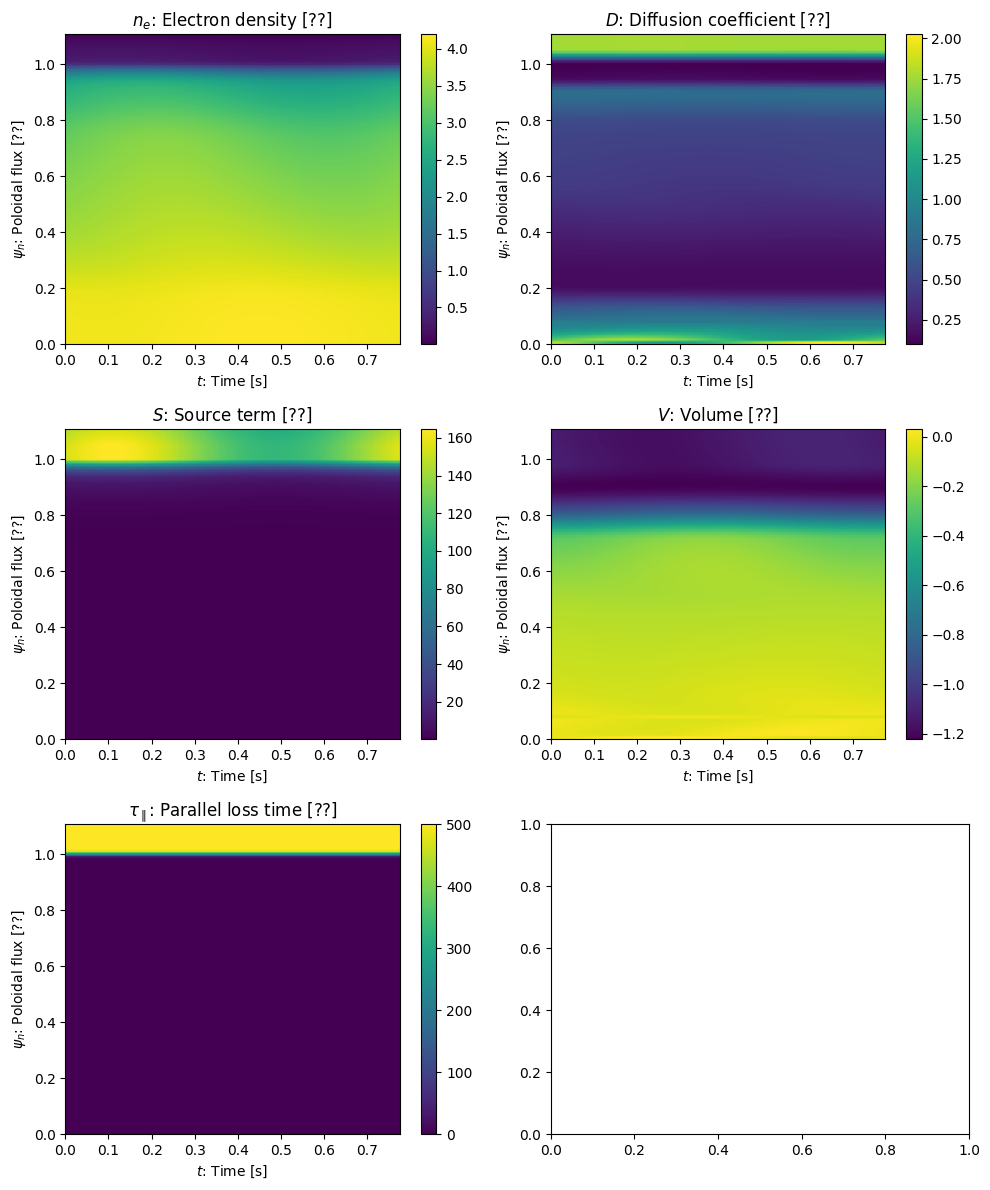

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Plot each subplot with labels and titles
data_array = [(n_e, r'$n_e$: Electron density [??]'),
              (D, r'$D$: Diffusion coefficient [??]'),
              (S, r'$S$: Source term [??]'),
              (V, r'$V$: Volume [??]'),
              (itaupar, r'$\tau_{\parallel}$: Parallel loss time [??]')]

for i, (data_array, title) in enumerate(data_array):
    ax = axes[i // 2, i % 2]
    c = ax.imshow(data_array, aspect='auto', origin='lower', extent=[t[0], t[-1], x[0], x[-1]])
    ax.set_xlabel(r'$t$: Time [s]')
    ax.set_ylabel(r'$\psi_n$: Poloidal flux [??]')
    ax.set_title(title)
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


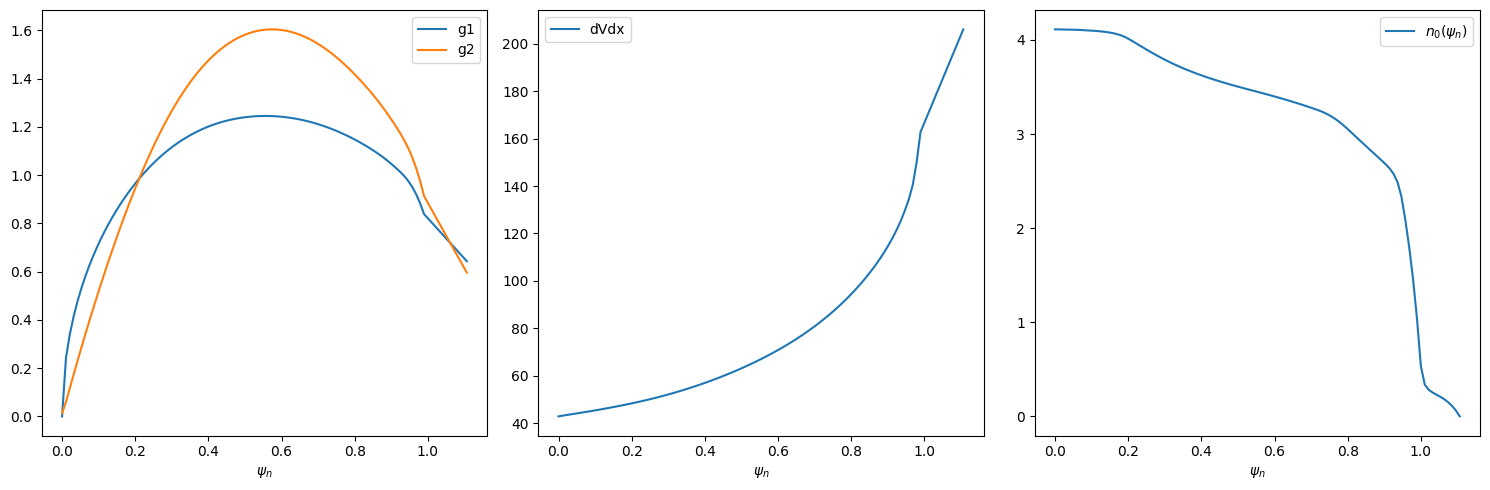

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(psi_n, g1, label='g1')
axes[0].plot(psi_n, g2, label='g2')
axes[0].set_xlabel(r'$\psi_n$')
axes[0].legend()

axes[1].plot(psi_n, dVdx, label='dVdx')
axes[1].set_xlabel(r'$\psi_n$')
axes[1].legend()

axes[2].plot(psi_n, n0, label=r'$n_0(\psi_n)$')
axes[2].set_xlabel(r'$\psi_n$')
axes[2].legend()

plt.tight_layout()
plt.show()

# Inspection of Plasma Data

In [ ]:
def print_datadict(data):
    pad = 60
    print("-"*pad)
    print("Key".ljust(20), "Shape or Value", "\tRange")
    print("-"*pad)
    for key in data:
        try:
            val = data[key].shape if data[key].shape != () else data[key]
            print(f"{key}".ljust(20), val, f"\t\t[{data[key].min():.2f}, {data[key].max():.2f}]")
        except:
            val = data[key] if type(data[key]) != np.ndarray else "dict"
            print(f"{key}".ljust(20), val)
    print("-"*pad)

In [ ]:
print(data['g1']-g1)

[[ 0.          0.24269384  0.34171614 ...  0.67891171  0.66114363
   0.64337556]
 [-0.24269384  0.          0.0990223  ...  0.43621786  0.41844979
   0.40068172]
 [-0.34171614 -0.0990223   0.         ...  0.33719557  0.31942749
   0.30165942]
 ...
 [-0.67891171 -0.43621786 -0.33719557 ...  0.         -0.01776807
  -0.03553614]
 [-0.66114363 -0.41844979 -0.31942749 ...  0.01776807  0.
  -0.01776807]
 [-0.64337556 -0.40068172 -0.30165942 ...  0.03553614  0.01776807
   0.        ]]


In [ ]:
print_datadict(data)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
psin                 (105,) 		[0.00, 1.11]
rhotor               (105,) 		[0.00, 1.05]
t                    (50,) 		[0.00, 0.78]
ne                   (105, 50) 		[0.01, 4.25]
te                   (105, 50) 		[27.71, 2360.24]
nbi_src              (105, 50) 		[0.00, 0.48]
eirene_src           (105,) 		[0.00, 136.83]
g1                   (105,) 		[0.00, 1.25]
g2                   (105,) 		[0.01, 1.60]
dVdpsin              (105,) 		[42.93, 206.01]
rmaj                 (105,) 		[2.80, 2.95]
area                 (105,) 		[0.00, 148.53]
te_data              dict
eq                   dict
prob                 dict
sol                  dict
o                    dict
fsa                  dict
coord                0 		[0.00, 0.00]
eq_full              dict
aaro_origsrc         (12,) 		[16499262690313633792.00, 3953118170992535928832.00

### $\texttt{te\_data}$ - 

In [ ]:
te_data = data['te_data'][()]
for key in te_data:
    print("-"*30)
    print(f"{key}".center(30, ' '))
    print("-"*30)
    for key2 in te_data[key]:
        try:
            print(f"{key2:<20} {te_data[key][key2].shape}")
        except:
            print(f"{key2:<20} {te_data[key][key2]}")
print("-"*30)

------------------------------
              te              
------------------------------
amp                  (105,)
pha                  (105,)
ss                   (105,)
freq                 1.29
amp_err              (105,)
pha_err              (105,)
ss_err               (105,)
------------------------------
             gte              
------------------------------
amp                  (105,)
pha                  (105,)
ss                   (105,)
freq                 1.29
amp_err              (105,)
pha_err              (105,)
ss_err               (105,)
------------------------------
             lte              
------------------------------
amp                  (105,)
pha                  (105,)
ss                   (105,)
freq                 1.29
amp_err              (105,)
pha_err              (105,)
ss_err               (105,)
------------------------------


### $\texttt{eq}$ - Equilibrium

In [ ]:
eq = data['eq'][()]
print_datadict(eq)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
t                    57.02857 		[57.03, 57.03]
psi                  (65, 65) 		[0.42, 2.71]
faxs                 0.42377034 		[0.42, 0.42]
fbnd                 1.5233516 		[1.52, 1.52]
rbnd                 (500,) 		[1.99, 3.80]
zbnd                 (500,) 		[-1.33, 1.76]
rmag                 2.952532 		[2.95, 2.95]
zmag                 0.38834146 		[0.39, 0.39]
rsil                 2.41572 		[2.42, 2.42]
rsol                 2.8846757 		[2.88, 2.88]
zsil                 -1.579748 		[-1.58, -1.58]
zsol                 -1.5784608 		[-1.58, -1.58]
rxpl                 2.6904309 		[2.69, 2.69]
zxpl                 -1.3255389 		[-1.33, -1.33]
rmjo                 (65,) 		[2.95, 3.80]
jsur                 (65,) 		[-1669086.62, 1.35]
q                    (65,) 		[1.04, 7.54]
volm                 72.44376 		[72.44, 72.44]
vjac     

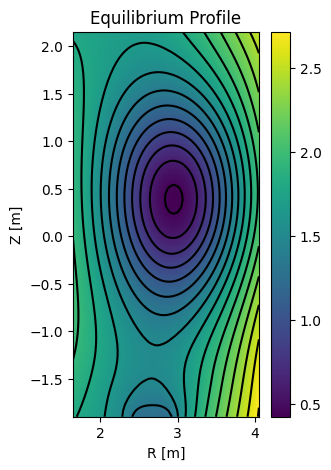

In [ ]:
# Plot
r = eq['r']
z = eq['z']
R, Z = np.meshgrid(r, z)

plt.figure(figsize=(3, 5))
plt.imshow(eq['psi'], extent=[r.min(), r.max(), z.min(), z.max()], origin='lower', aspect='auto')
plt.colorbar()
plt.contour(R, Z, eq['psi'], 20, colors='black')
plt.title('Equilibrium Profile')
plt.xlabel('R [m]')
plt.ylabel('Z [m]')
plt.show()

### $\texttt{prob}$ - Optimization problem?

In [ ]:
prob = data['prob'][()]
print_datadict(prob)


------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
x                    (105,) 		[0.00, 1.11]
D                    (105, 50) 		[0.10, 2.02]
V                    (105, 50) 		[-1.22, 0.03]
S                    (105, 50) 		[0.00, 164.54]
dVdx                 (105,) 		[42.93, 206.01]
g1                   (105,) 		[0.00, 1.25]
g2                   (105,) 		[0.01, 1.60]
bc                   (50,) 		[0.00, 0.00]
n0                   (105,) 		[0.00, 4.11]
tout                 (50,) 		[0.00, 0.78]
itaupar              (105, 50) 		[0.00, 500.00]
do_not_fail          True
maxcycles            50.0
nx                   95.0
nt                   50.0
src_wid              0.05
rtol                 0.0001
print                100.0
alpha                10.0
amp_wgt              200000.0
optiter              20000.0
psin_max             1.1
dt_mul               1.0
nloop                10.

### $\texttt{sol}$ - Solution

In [ ]:
sol = data['sol'][()]
print_datadict(sol)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
ne                   (105, 50) 		[0.00, 4.20]
t                    (50,) 		[0.00, 0.78]
x                    (105,) 		[0.00, 1.11]
Nsteps               102392
Ncycles              2
t_used               0.009387016296386719
------------------------------------------------------------


### $\texttt{o}$ - Output

In [ ]:
o = data['o'][()]
print_datadict(o)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
amp                  (105,) 		[55742942661869368.00, 2010584496510536704.00]
pha                  (105,) 		[5.25, 8.40]
ss                   (105,) 		[218923911161990880.00, 42186665658966581248.00]
freq                 1.29
amp_err              (105,) 		[0.00, 45179244277026272.00]
pha_err              (105,) 		[0.00, 0.10]
ss_err               (105,) 		[0.00, 32709007077067620.00]
rho                  (105,) 		[0.00, 1.05]
------------------------------------------------------------


### $\texttt{fsa}$ - Flux Surface Averaging

In [ ]:
fsa = data['fsa'][()]
print_datadict(fsa)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
Bp                   (105,) 		[-0.17, 0.47]
<grad(rhot)>         (105,) 		[0.88, 5.62]
<grad(rhot)**2>      (105,) 		[0.78, 16.65]
<grad(rhop)>         (105,) 		[-0.24, 1.36]
<grad(rhop)**2>      (105,) 		[-0.20, 1.85]
R                    (105,) 		[2.56, 2.95]
R**2                 (105,) 		[6.41, 8.87]
<grad(psin)>         (105,) 		[-0.46, 1.25]
<grad(psin)**2>      (105,) 		[-0.74, 1.60]
Area                 (105,) 		[0.00, 168.84]
dVpsin               (105,) 		[42.93, 217.07]
dVpol                (105,) 		[0.00, 443.29]
dVtor                (105,) 		[0.00, 132.57]
rhopol               (105,) 		[0.00, 1.05]
rhotor               (105,) 		[-0.00, 1.91]
psin                 (105,) 		[-0.00, 1.11]
Vol                  (105,) 		[0.00, 91.11]
------------------------------------------------------------


### $\texttt{eq\_full}$ - Full equilibrium

In [ ]:
eq_full = data['eq_full'][()]
print_datadict(eq_full)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
psi                  (279, 65, 65) 		[-1.13, 3.17]
faxs                 (279,) 		[-1.13, 1.71]
fbnd                 (279,) 		[-0.97, 2.05]
rbnd                 (279, 500) 		[1.84, 3.89]
zbnd                 (279, 500) 		[-1.46, 1.88]
rmag                 (279,) 		[2.87, 3.18]
zmag                 (279,) 		[0.11, 0.40]
rxpl                 (279,) 		[0.00, 2.70]
zxpl                 (279,) 		[-1.46, 0.00]
rmjo                 (279, 65) 		[2.87, 3.89]
jsur                 (279, 65) 		[-1979434.00, 152767.77]
q                    (279, 65) 		[0.85, 51.57]
volm                 (279,) 		[40.30, 82.00]
vjac                 (279, 65) 		[21.47, 283.26]
zsol                 (279,) 		[-1.74, 0.00]
rsol                 (279,) 		[0.00, 2.94]
rsil                 (279,) 		[0.00, 2.42]
zsil                 (279,) 		[-1.73, 0.00]
f        

## Visualize data

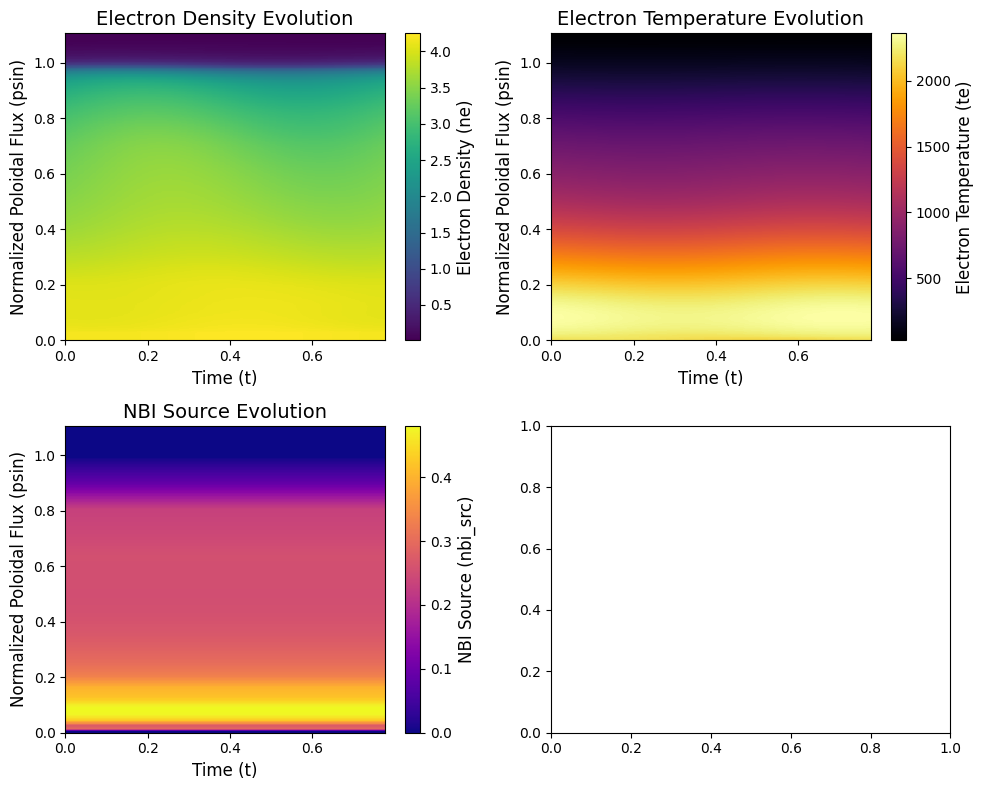

In [ ]:
# Create meshgrid
PSIN, T = np.meshgrid(data['psin'], data['t'], indexing='ij')

# Create the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot for Electron Density (ne)
im1 = axes[0, 0].imshow(data['ne'], aspect='auto', origin='lower', 
                     extent=[data['t'].min(), data['t'].max(), data['psin'].min(), data['psin'].max()], 
                     cmap='viridis')
cbar1 = fig.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Electron Density (ne)', fontsize=12)
axes[0, 0].set_xlabel('Time (t)', fontsize=12)
axes[0, 0].set_ylabel('Normalized Poloidal Flux (psin)', fontsize=12)
axes[0, 0].set_title('Electron Density Evolution', fontsize=14)

# Plot for Electron Temperature (te)
im2 = axes[0, 1].imshow(data['te'], aspect='auto', origin='lower', 
                     extent=[data['t'].min(), data['t'].max(), data['psin'].min(), data['psin'].max()], 
                     cmap='inferno')
cbar2 = fig.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('Electron Temperature (te)', fontsize=12)
axes[0, 1].set_xlabel('Time (t)', fontsize=12)
axes[0, 1].set_ylabel('Normalized Poloidal Flux (psin)', fontsize=12)
axes[0, 1].set_title('Electron Temperature Evolution', fontsize=14)

# Plot nbi_src
im3 = axes[1, 0].imshow(data['nbi_src'], aspect='auto', origin='lower', 
                     extent=[data['t'].min(), data['t'].max(), data['psin'].min(), data['psin'].max()], 
                     cmap='plasma')
cbar3 = fig.colorbar(im3, ax=axes[1, 0])
cbar3.set_label('NBI Source (nbi_src)', fontsize=12)
axes[1, 0].set_xlabel('Time (t)', fontsize=12)
axes[1, 0].set_ylabel('Normalized Poloidal Flux (psin)', fontsize=12)
axes[1, 0].set_title('NBI Source Evolution', fontsize=14)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [ ]:
import torch

T, X = np.meshgrid(t, x)

z = torch.tensor(np.concatenate([T.reshape(-1, 1), X.reshape(-1, 1)], axis=1), dtype=torch.float32)
U = torch.tensor(D.reshape(-1, 1), dtype=torch.float32)

In [ ]:
# Approximate each term with a neural network
hidden2d = [16]*3
hidden1d = [32]*2
# D_net = UPINN(FNN([2, *hidden2d, 1]), data_points=(z, torch.tensor(D.reshape(-1, 1), dtype=torch.float32)))
# V_net = UPINN(FNN([2, *hidden2d, 1]), data_points=(z, torch.tensor(V.reshape(-1, 1), dtype=torch.float32)))
# S_net = UPINN(FNN([2, *hidden2d, 1]), data_points=(z, torch.tensor(S.reshape(-1, 1), dtype=torch.float32)))
# itau_net = UPINN(FNN([2, *hidden2d, 1]), data_points=(z, torch.tensor(itaupar.reshape(-1, 1), dtype=torch.float32)))
# ne_net = UPINN(FNN([2, *hidden2d, 1]), data_points=(z, torch.tensor(n_e.reshape(-1, 1), dtype=torch.float32)))
# dVdx_net = UPINN(FNN([1, *hidden1d, 1], hidden_act=torch.nn.ReLU()), data_points=(torch.tensor(x.reshape(-1, 1), dtype=torch.float32), torch.tensor(dVdx.reshape(-1, 1), dtype=torch.float32)))
g1_net = UPINN(FNN([1, *hidden1d, 1], hidden_act=torch.nn.ReLU()), data_points=(torch.tensor(x.reshape(-1, 1), dtype=torch.float32), torch.tensor(g1.reshape(-1, 1), dtype=torch.float32)))
# g2_net = UPINN(FNN([1, *hidden1d, 1], hidden_act=torch.nn.ReLU()), data_points=(torch.tensor(x.reshape(-1, 1), dtype=torch.float32), torch.tensor(g2.reshape(-1, 1), dtype=torch.float32)))
# n0_net = UPINN(FNN([1, *hidden1d, 1], hidden_act=torch.nn.ReLU()), data_points=(torch.tensor(x.reshape(-1, 1), dtype=torch.float32), torch.tensor(n0.reshape(-1, 1), dtype=torch.float32)))

# # Train the neural networks
# D_net.train_loop(epochs=50000)
# V_net.train_loop(epochs=50000)
# S_net.train_loop(epochs=50000)
# itau_net.train_loop(epochs=50000)
# ne_net.train_loop(epochs=50000)
# dVdx_net.train_loop(epochs=50000)
g1_net.train_loop(epochs=50000)
# g2_net.train_loop(epochs=50000)
# n0_net.train_loop(epochs=50000)

# D_net.save('D_net', 'PlasmaNet')
# V_net.save('V_net', 'PlasmaNet')
# S_net.save('S_net', 'PlasmaNet')
# itau_net.save('itau_net', 'PlasmaNet')
# ne_net.save('ne_net', 'PlasmaNet')
# dVdx_net.save('dVdx_net', 'PlasmaNet')
g1_net.save('g1_net3', 'PlasmaNet')
# g2_net.save('g2_net', 'PlasmaNet')
# n0_net.save('n0_net', 'PlasmaNet')


[Info]: Initializing NN model (Known dynamics F unspecified; Setting F and G to 0.0)
[Info]: Beginning training...


[CUDA]:   1%|          | 563/50000 [00:02<03:38, 225.80 epoch/s, L=6.94e-03, L_ic=0.00e+00, L_bc=0.00e+00, L_data=6.94e-03, L_pde=0.00e+00]


KeyboardInterrupt: 

### Approximating networks

In [ ]:
g1_net = FNN([1, 8, 8, 8, 1], hidden_act=torch.nn.ReLU())
g1_net.load_state_dict(torch.load('PlasmaNet/g1_net2_u.pth'))

C:\Users\jonas\AppData\Local\Temp\ipykernel_6904\1026729876.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g1_net.load_state_dict(torch.load('PlasmaNet/g1_net2_u.pth'))

<All keys matched successfully>

In [ ]:
hidden2d = [16]*3
hidden1d = [8]
D_net, V_net, S_net, itau_net, ne_net = [
    (net := FNN([2, *hidden2d, 1]), net.load_state_dict(torch.load(f'PlasmaNet/{name}_u.pth', weights_only=True)), net)[2]
    for name in ['D_net', 'V_net', 'S_net', 'itau_net', 'ne_net']
]
dVdx_net, g1_net, g2_net, n0_net = [
    (net := FNN([1, *hidden1d, 1]), net.load_state_dict(torch.load(f'PlasmaNet/{name}_u.pth', weights_only=True)), net)[2]
    for name in ['dVdx_net', 'g1_net3', 'g2_net', 'n0_net']
]

RuntimeError: Error(s) in loading state_dict for FNN:
	Unexpected key(s) in state_dict: "layers.2.weight", "layers.2.bias". 
	size mismatch for layers.0.weight: copying a param with shape torch.Size([32, 1]) from checkpoint, the shape in current model is torch.Size([8, 1]).
	size mismatch for layers.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layers.1.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([1, 8]).
	size mismatch for layers.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([1]).

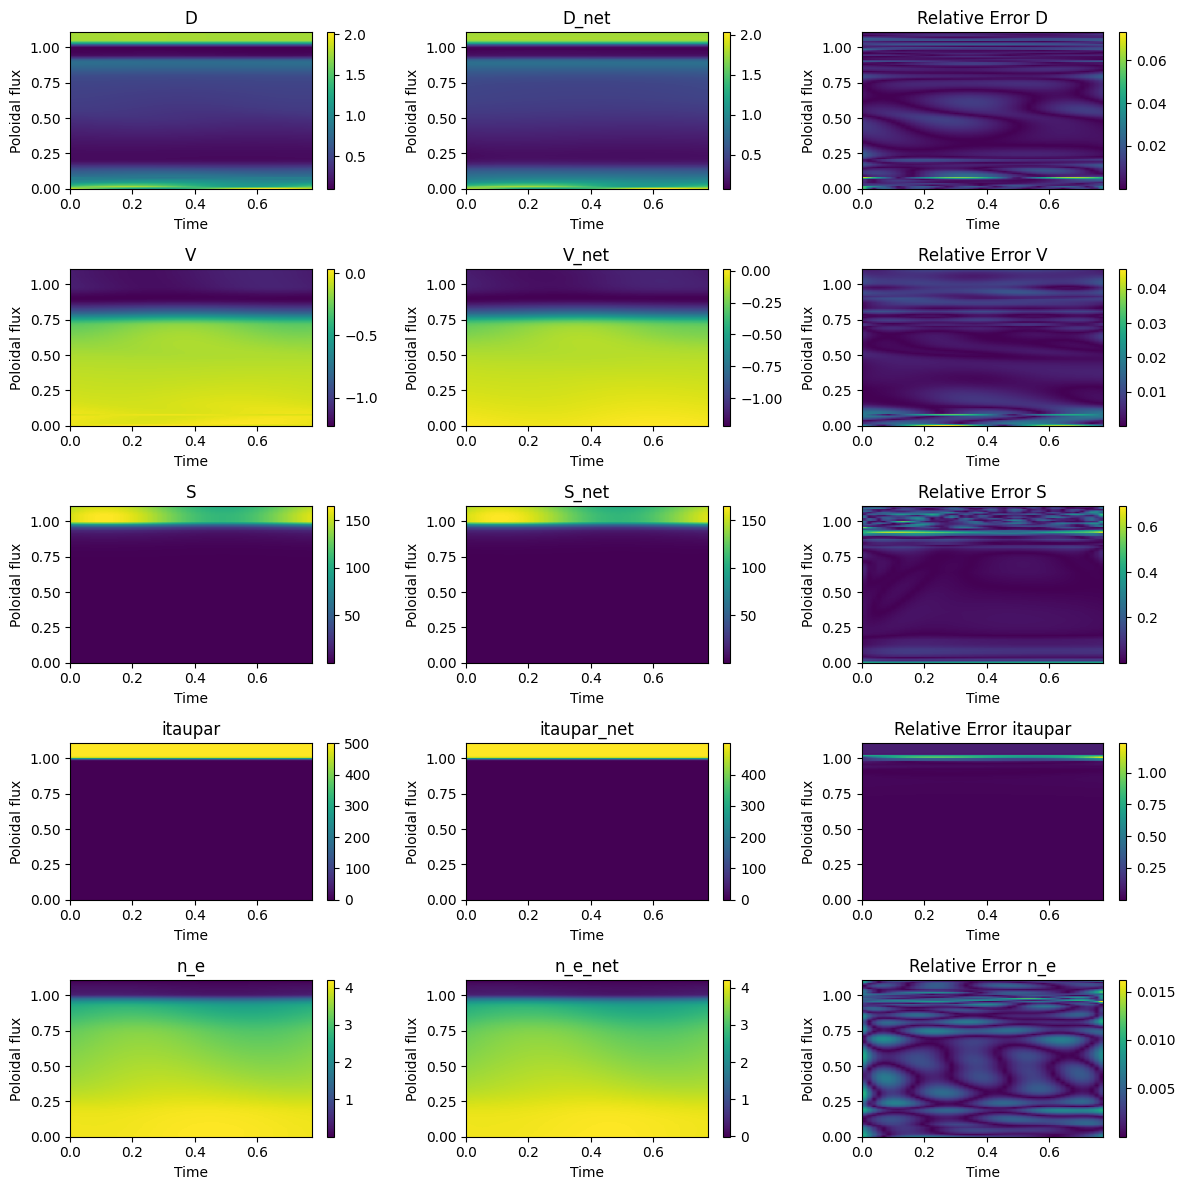

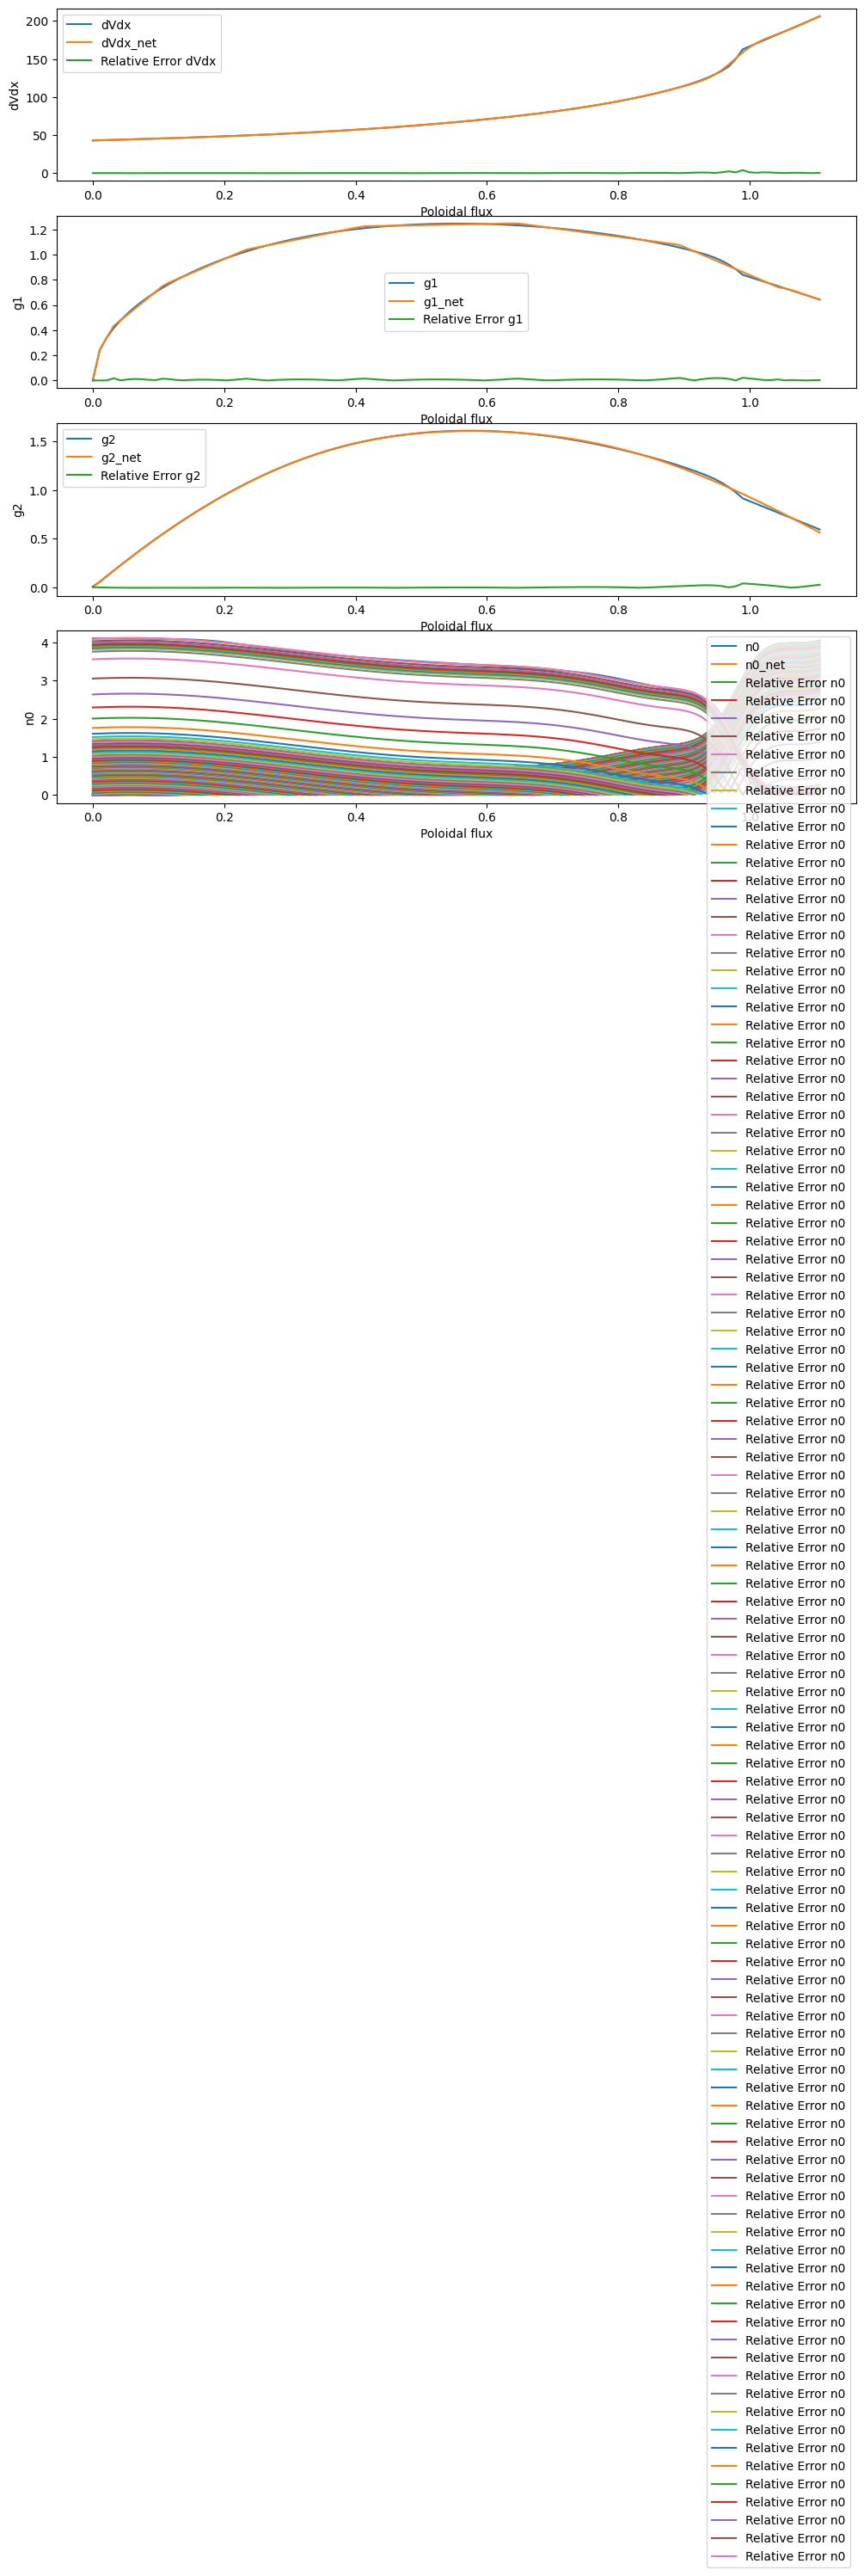

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
params = [('D', D, D_net), ('V', V, V_net), ('S', S, S_net), ('itaupar', itaupar, itau_net), ('n_e', n_e, ne_net)]

for i, (label, true_val, net_func) in enumerate(params):
    net_val = net_func(z).detach().numpy().reshape(len(x), len(t))
    abs_error = abs(true_val - net_val)
    for j, (data, title) in enumerate([(true_val, label), (net_val, f'{label}_net'), (abs_error, f'Relative Error {label}')]):
        im = axs[i, j].imshow(data, aspect='auto', origin='lower', extent=[t[0], t[-1], x[0], x[-1]])
        axs[i, j].set_title(title)
        axs[i, j].set_xlabel('Time')
        axs[i, j].set_ylabel('Poloidal flux')
        plt.colorbar(im, ax=axs[i, j])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
params = [('dVdx', dVdx, dVdx_net), ('g1', g1, g1_net), ('g2', g2, g2_net), ('n0', n0, n0_net)]

for i, (label, true_val, net_func) in enumerate(params):
    net_val = net_func(torch.tensor(x.reshape(-1, 1), dtype=torch.float32)).detach().numpy()
    abs_error = abs(true_val - net_val)
    for j, (data, title) in enumerate([(true_val, label), (net_val, f'{label}_net'), (abs_error, f'Relative Error {label}')]):
        axs[i].plot(x, data, label=title)
        axs[i].set_xlabel('Poloidal flux')
        axs[i].set_ylabel(label)
        axs[i].legend()
        

In [ ]:
# Use the trained model to upscale x4
x_up = np.linspace(x[0], x[-1], 4*len(x))
t_up = np.linspace(t[0], t[-1], 4*len(t))

T_up, X_up = np.meshgrid(t_up, x_up)

z_up = torch.tensor(np.concatenate([T_up.reshape(-1, 1), X_up.reshape(-1, 1)], axis=1), dtype=torch.float32)
D_pred = model.predict(z_up).reshape(len(x_up), len(t_up)).detach().numpy()

# Plot the results
plt.imshow(D_pred, aspect='auto', origin='lower', extent=[t_up[0], t_up[-1], x_up[0], x_up[-1]])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Poloidal flux')
plt.title('Diffusion coefficient')
plt.show()

plt.imshow(D, aspect='auto', origin='lower', extent=[t[0], t[-1], x[0], x[-1]])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Poloidal flux')
plt.title('Diffusion coefficient')
plt.show()

NameError: name 'model' is not defined